# Финальное задание

## Подход 1: градиентный бустинг "в лоб"
Один из самых универсальных алгоритмов, изученных в нашем курсе, является градиентный бустинг. Он не очень требователен к данным, восстанавливает нелинейные зависимости, и хорошо работает на многих наборах данных, что и обуславливает его популярность. Вполне разумной мыслью будет попробовать именно его в первую очередь.

Считайте таблицу с признаками из файла features.csv с помощью кода, приведенного выше. Удалите признаки, связанные с итогами матча (они помечены в описании данных как отсутствующие в тестовой выборке).

In [1]:
import pandas as pd
import numpy as np

datapath = '../data'

features = pd.read_csv(datapath + '/features.csv', index_col='match_id')
features.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,3,3,0,-16.0,2449,0,4,1974,3,63


Проверьте выборку на наличие пропусков с помощью функции count(), которая для каждого столбца показывает число заполненных значений. Много ли пропусков в данных? Запишите названия признаков, имеющих пропуски, и попробуйте для любых двух из них дать обоснование, почему их значения могут быть пропущены.

In [2]:
data_gaps = (len(features) - features.count()) / len(features)
data_gaps.sort_values(ascending=False, inplace=True)
print(f'Пропуски в данных:\n{data_gaps[data_gaps > 0]}')

Пропуски в данных:
first_blood_player2            0.452402
radiant_flying_courier_time    0.282619
dire_flying_courier_time       0.268415
first_blood_player1            0.201100
first_blood_team               0.201100
first_blood_time               0.201100
dire_bottle_time               0.166029
radiant_bottle_time            0.161380
radiant_first_ward_time        0.018883
dire_first_ward_time           0.018780
radiant_courier_time           0.007117
dire_courier_time              0.006953
dtype: float64


>Как мы можем видеть пропуски в признаках присутствуют и довольно существенные. Самым не заполненным признаком является first_blood_player2 (ассист первой крови). И в самом деле не в каждой игре первая кровь происходит с поддержкой и не всегда первая кровь приходится на первые пяти минут игры (first_blood_player1).

>В целом тут по поводу всех не заполненных признаков можно сказать, что это из-за того, что определенное событие не произошло за первые пять минут игры.

Замените пропуски на нули с помощью функции fillna(). На самом деле этот способ является предпочтительным для логистической регрессии, поскольку он позволит пропущенному значению не вносить никакого вклада в предсказание. Для деревьев часто лучшим вариантом оказывается замена пропуска на очень большое или очень маленькое значение — в этом случае при построении разбиения вершины можно будет отправить объекты с пропусками в отдельную ветвь дерева. Также есть и другие подходы — например, замена пропуска на среднее значение признака. Мы не требуем этого в задании, но при желании попробуйте разные подходы к обработке пропусков и сравните их между собой.

>Для всех временных признаков вполне разумно установить самое большое значение. А для всех категориальных признаков ввести новую категорию, например -1, которая означает, что событие не случилось.


In [3]:
NO_ONE = -1
MAX_TIME = 300.0

features_gaps = data_gaps[data_gaps > 0].index
nan_replace = { f: MAX_TIME if 'time' in f else NO_ONE for f in features_gaps}

features.fillna(nan_replace, inplace=True)

future_features = [
    'duration',
    'radiant_win',
    'tower_status_radiant',
    'tower_status_dire',
    'barracks_status_radiant',
    'barracks_status_dire'
    ]

train = features.drop(future_features, axis=1)


3. Какой столбец содержит целевую переменную? Запишите его название.

In [4]:
target = 'radiant_win'


4. Забудем, что в выборке есть категориальные признаки, и попробуем обучить градиентный бустинг над деревьями на имеющейся матрице "объекты-признаки". Зафиксируйте генератор разбиений для кросс-валидации по 5 блокам (KFold), не забудьте перемешать при этом выборку (shuffle=True), поскольку данные в таблице отсортированы по времени, и без перемешивания можно столкнуться с нежелательными эффектами при оценивании качества. Оцените качество градиентного бустинга (GradientBoostingClassifier) с помощью данной кросс-валидации, попробуйте при этом разное количество деревьев (как минимум протестируйте следующие значения для количества деревьев: 10, 20, 30). Долго ли настраивались классификаторы? Достигнут ли оптимум на испытанных значениях параметра n_estimators, или же качество, скорее всего, продолжит расти при дальнейшем его увеличении?


> Данный процесс занимает приличное время (около 5 минут для моей системы). Рекомендую устанавливать параметр `n_jobs` равным числу ядер.

In [5]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

X = train[:]
y = features[target]

n_estimators = [10, 20, 30, 40]
cv = KFold(n_splits=5, shuffle=True)
grid = {'n_estimators': n_estimators}
scoring = {'accuracy': 'accuracy', 'loss': 'neg_log_loss', 'AUC': 'roc_auc'}
gb_model = GridSearchCV(
    GradientBoostingClassifier(verbose=True),
    grid, cv=cv,
    scoring=scoring, refit='AUC', return_train_score=True,
    n_jobs=4, verbose=10)
gb_model.fit(X, y);

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   53.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done  16 out of  20 | elapsed:  4.5min remaining:  1.1min
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  5.6min finished
      Iter       Train Loss   Remaining Time 
         1           1.3786           55.84s
         2           1.3732           54.08s
         3           1.3681           52.61s
         4           1.3636           51.29s
         5           1.3589           49.81s
         6           1.3547           48.51s
         7           1.3502           47.12s
         8           1.3461           45.61s
         9           1.3422           44.13s
        10           1.3385           42.69s
        20           1.3092           28.31s
        30           1.2892           14.15s
       

### AUC_ROC

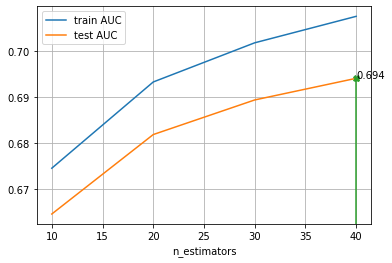

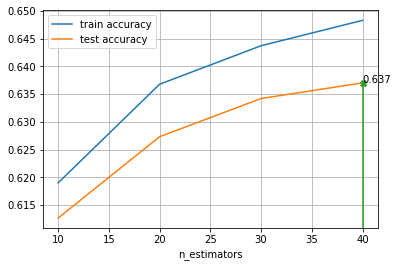

In [6]:
import matplotlib.pyplot as plt

def plot_model_efficiency(model, param, scoring, xscale='linear'):
    [[pname, pvalue]] = param.items()
    for score in scoring:
        for mode in ('train', 'test'):
            plt.plot(pvalue, model.cv_results_[f'mean_{mode}_{score}'],
            label=f'{mode} {score}')
        test_score = model.cv_results_[f'mean_test_{score}']
        bsi = np.argmax(test_score)
        plt.xscale(xscale)
        ax = plt.axis()
        plt.plot([pvalue[bsi], pvalue[bsi]], [0, test_score[bsi]],
                 linestyle='-', marker='X')
        plt.annotate(f'{test_score[bsi]:.3f}', [pvalue[bsi], test_score[bsi]])
        plt.axis(ax)
        plt.grid()
        plt.xlabel(pname)
        plt.legend(loc='upper left')
        plt.show()

plot_model_efficiency(gb_model, grid, ('AUC', 'accuracy'))

### Время обучения

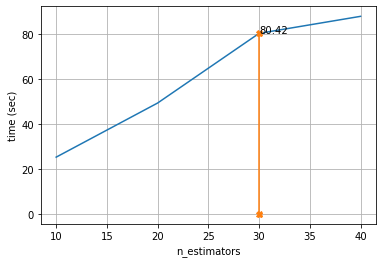

In [7]:
time_for_30 = gb_model.cv_results_['mean_fit_time'][2]
plt.plot(n_estimators, gb_model.cv_results_['mean_fit_time'])
plt.plot([30, 30], [0, time_for_30],
 linestyle='-', marker='X')
plt.annotate(f'{time_for_30:.2f}', [30, time_for_30])
plt.grid()
plt.xlabel('n_estimators')
plt.ylabel('time (sec)');



### Что указать в отчете
В отчете по данному этапу вы должны ответить на следующие вопросы:

1. Какие признаки имеют пропуски среди своих значений? Что могут означать пропуски в этих признаках (ответьте на этот вопрос для двух любых признаков)?
2. Как называется столбец, содержащий целевую переменную?
3. Как долго проводилась кросс-валидация для градиентного бустинга с 30 деревьями? Инструкцию по измерению времени можно найти ниже по тексту. Какое качество при этом получилось? Напомним, что в данном задании мы используем метрику качества AUC-ROC.
4. Имеет ли смысл использовать больше 30 деревьев в градиентном бустинге? Что бы вы предложили делать, чтобы ускорить его обучение при увеличении количества деревьев?

## Подход 2: логистическая регрессия

Линейные методы работают гораздо быстрее композиций деревьев, поэтому кажется разумным воспользоваться именно ими для ускорения анализа данных. Одним из наиболее распространенных методов для классификации является логистическая регрессия.

**Важно:** не забывайте, что линейные алгоритмы чувствительны к масштабу признаков! Может пригодиться `sklearn.preprocessing.StandartScaler`.

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    8.2s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   13.6s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   21.4s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   27.2s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   31.7s finished


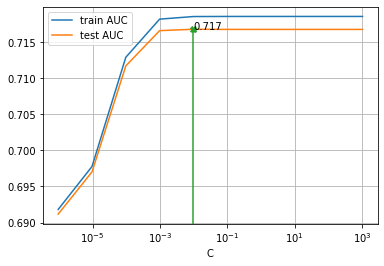

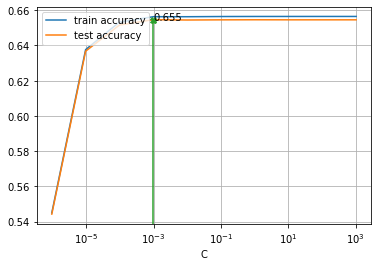

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()
X_norm = scaler.fit_transform(X)
grid = {'C': 2**np.linspace(-20, 10, 10)}
scoring = {'accuracy': 'accuracy', 'loss': 'neg_log_loss', 'AUC': 'roc_auc'}

log_model = GridSearchCV(LogisticRegression(),
                     grid, cv=cv,
                     scoring=scoring, refit='AUC', return_train_score=True,
                     n_jobs=4, verbose=10)
log_model.fit(X_norm, y)
plot_model_efficiency(log_model, grid, ('AUC', 'accuracy'), xscale='log')


2. Среди признаков в выборке есть категориальные, которые мы использовали как числовые, что вряд ли является хорошей идеей. Категориальных признаков в этой задаче одиннадцать: lobby_type и r1_hero, r2_hero, ..., r5_hero, d1_hero, d2_hero, ..., d5_hero. Уберите их из выборки, и проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Изменилось ли качество? Чем вы можете это объяснить?


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    4.4s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    7.5s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   13.2s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   18.4s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   22.3s finished


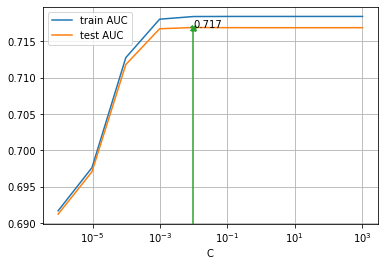

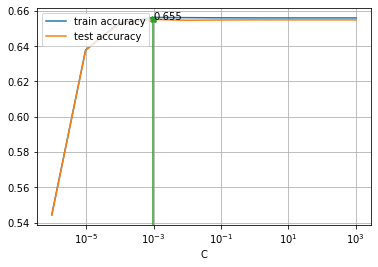

In [9]:
heroes_features = [f'{team}{n}_hero' for team in ('d', 'r') for n in range(1, 6)]
categorical_features =  ['lobby_type'] + heroes_features
X = train.drop(categorical_features, axis=1)
X_norm = scaler.fit_transform(X)

log_model.fit(X_norm, y)
plot_model_efficiency(log_model, grid, ('AUC', 'accuracy'), xscale='log')

> Как мы можем видеть после исключения категориальных признаков качество итоговой модели не изменилось. Из чего можно сделать вывод, что они не оказывали значение на результат.

3. На предыдущем шаге мы исключили из выборки признаки rM_hero и dM_hero, которые показывают, какие именно герои играли за каждую команду. Это важные признаки — герои имеют разные характеристики, и некоторые из них выигрывают чаще, чем другие. Выясните из данных, сколько различных идентификаторов героев существует в данной игре (вам может пригодиться фукнция unique или value_counts).

In [10]:
heroes_count = np.max(train[heroes_features].values)
heroes_ids = np.arange(heroes_count)
print(f'Число героев: {heroes_count}')

Число героев: 112


4. Воспользуемся подходом "мешок слов" для кодирования информации о героях. Пусть всего в игре имеет N различных героев. Сформируем N признаков, при этом i-й будет равен нулю, если i-й герой не участвовал в матче; единице, если i-й герой играл за команду Radiant; минус единице, если i-й герой играл за команду Dire. Ниже вы можете найти код, который выполняет данной преобразование. Добавьте полученные признаки к числовым, которые вы использовали во втором пункте данного этапа.


In [11]:
X_pick = np.zeros((features.shape[0], heroes_count))

for i, match_id in enumerate(features.index):
    for p in range(5):
        X_pick[i, features.loc[match_id, f'r{p+1}_hero'] - 1] = 1
        X_pick[i, features.loc[match_id, f'd{p+1}_hero'] - 1] = -1
X_norm = np.append(X_norm, X_pick, axis=1)

5. Проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Какое получилось качество? Улучшилось ли оно? Чем вы можете это объяснить?

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   11.2s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   22.7s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   45.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  1.4min finished


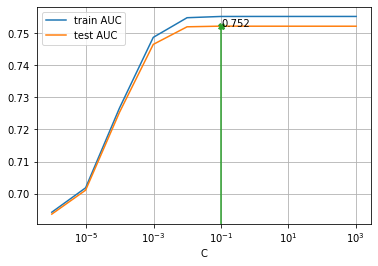

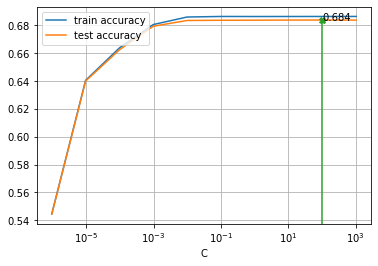

In [12]:
log_model.fit(X_norm, y)
plot_model_efficiency(log_model, grid, ('AUC', 'accuracy'), xscale='log')

>Здесь прекрасно видно, что качество модели в виде АUC_ROC вырасло с 0.71 до 0.75. Из чего можно сделать вывод, что правильное представление признаков имеет большое значение для линейных моделий.


6. Постройте предсказания вероятностей победы команды Radiant для тестовой выборки с помощью лучшей из изученных моделей (лучшей с точки зрения AUC-ROC на кросс-валидации). Убедитесь, что предсказанные вероятности адекватные — находятся на отрезке \[0, 1\], не совпадают между собой (т.е. что модель не получилась константной).


In [13]:
test_data = pd.read_csv(f'{datapath}/features.csv', index_col='match_id')

def prepare_data(data):
    data.fillna(nan_replace, inplace=True)
    y = data[target].to_numpy()
    X_pick = np.zeros((features.shape[0], heroes_count))

    for i, match_id in enumerate(data.index):
        for p in range(5):
            X_pick[i, data.loc[match_id, f'r{p+1}_hero'] - 1] = 1
            X_pick[i, data.loc[match_id, f'd{p+1}_hero'] - 1] = -1
    data = data.drop(future_features + categorical_features, axis=1)
    X = np.append(data.to_numpy(), X_pick, axis=1)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return X, y

X, y = prepare_data(test_data)
best_model = log_model.best_estimator_
best_model.fit(X, y)
z = best_model.predict_proba(X)
print(f'Проверка границ: [{np.min(z):.2f}, {np.max(z):.2f}]')
print(f'Проверка значений: {len(np.unique(z))}')


Проверка границ: [0.00, 1.00]
Проверка значений: 194460



##### Что указать в отчете
В отчете по данному этапу вы должны ответить на следующие вопросы:

1. Какое качество получилось у логистической регрессии над всеми исходными признаками? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?
2. Как влияет на качество логистической регрессии удаление категориальных признаков (укажите новое значение метрики качества)? Чем вы можете объяснить это изменение?
3. Сколько различных идентификаторов героев существует в данной игре?
4. Какое получилось качество при добавлении "мешка слов" по героям? Улучшилось ли оно по сравнению с предыдущим вариантом? Чем вы можете это объяснить?
5. Какое минимальное и максимальное значение прогноза на тестовой выборке получилось у лучшего из алгоритмов?